In [2]:
import tensorflow as tf
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from functools import reduce
import os
import shutil
from cifar import read_data_sets, onehot_to_names

In [3]:
cifar_data = read_data_sets("data", one_hot=True)

cifar data directory found data/cifar-10-batches-py
loading data...
dtype is float, normalize images to [0, 1]
dtype is float, normalize images to [0, 1]
dtype is float, normalize images to [0, 1]


In [4]:
cifar_data.train.num_examples

45245

In [5]:
cifar_data.validation.num_examples

4755

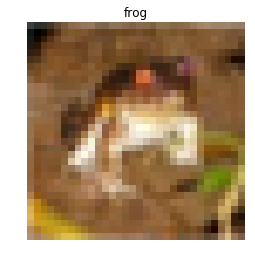

In [12]:
plt.axis('off')
plt.title(onehot_to_names(cifar_data.train.labels[0])[0])
plt.imshow(cifar_data.train.images[0].reshape((32, 32, 3)))

In [13]:
cifar_data.train.labels[0]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.])

In [19]:
def get_conv_filter(width, height, in_channels, out_channels,
                     dtype=tf.float32, initializer=None, seed=None, name=None):
    """
    arguments
    =========
    - width: int, filter width
    - height: int, filter height
    - in_channels: int, input channel
    - out_channels: int, output channel
    - dtype: data type
    - initializer: filter initializer
    - seed: random seed of the initializer
    """
    if initializer is None:
        initializer = tf.glorot_normal_initializer(seed=seed, dtype=dtype)
    filter_shape = [width, height, in_channels, out_channels]
    return tf.Variable(initializer(shape=filter_shape), name=name)

In [20]:
def build_model(images_batch, num_class=10, graph=None):
    """
    Simple VGG-like model
    
    Arguments
    =========
    - images_batch: placeholder for batch images (NHWC)
    - graph: the graph to build model within.
    """
    if graph is None:
        graph = tf.get_default_graph()
    
    initializer = tf.glorot_normal_initializer(dtype=tf.float32)
    with graph.as_default():
        # conv1
        with tf.name_scope("conv1"):
            filter_1 = get_conv_filter(3, 3, 3, 32, 
                                       name="filter", 
                                       initializer=initializer)
            fmap1 = tf.nn.conv2d(images_batch, filter_1, 
                                 strides=[1, 2, 2, 1],
                                 padding="VALID", name="feature_map")
            act1 = tf.nn.relu(fmap1, name="activation")
    
        # conv2
        with tf.name_scope("conv2"):
            filter_2 = get_conv_filter(3, 3, 32, 32, 
                                       name="filter", 
                                       initializer=initializer)
            fmap2 = tf.nn.conv2d(act1, filter_2,
                                 strides=[1, 2, 2, 1],
                                 padding="VALID", name="feature_map")
            act2 = tf.nn.relu(fmap2, name="activation")
    
        # max_pool
        with tf.name_scope("pool1"):
            pool = tf.nn.max_pool(act2, ksize=[1, 2, 2, 1], strides=[1, 1, 1, 1], padding="VALID")
            
        # 1x1 conv
        with tf.name_scope("conv3_1_by_1"):
            filter_3 = get_conv_filter(1, 1, 32, 16, 
                                       name="filter", 
                                       initializer=initializer)
            fmap3 = tf.nn.conv2d(pool, filter_3,
                                 strides=[1, 1, 1, 1],
                                 padding="SAME", name="feature_map")
            
        # fc layer
        fc_dim = reduce(lambda acc, d: acc*d, fmap3.shape.as_list()[1:], 1)
        with tf.name_scope("fc1"):
            flat_fmap3 = tf.reshape(fmap3, [-1, fc_dim])
            w1 = tf.Variable(initializer(shape=[fc_dim, 512]), 
                             dtype=tf.float32,
                             name="weight")
            b1 = tf.Variable(np.zeros(512), dtype=tf.float32, name="bias")
            z1 = tf.nn.bias_add(tf.matmul(flat_fmap3, w1), b1, name="z_score")
            act_fc1 = tf.nn.relu(z1)
        
        with tf.name_scope("fc2"):
            w2 = tf.Variable(initializer(shape=[512, num_class]),
                             dtype=tf.float32,
                             name="weight")
            b2 = tf.Variable(np.zeros(num_class), dtype=tf.float32, name="bias")
            logits = tf.nn.bias_add(tf.matmul(act_fc1, w2), b2, name="logits") 
    return graph

In [21]:
img_width, img_height = 32, 32

In [22]:
graph = tf.Graph()
with graph.as_default():
    image_batch = tf.placeholder(tf.float32, [None, img_width, img_height, 3], name="image_batch")
_ = build_model(image_batch, graph=graph)

In [23]:
for n in graph.as_graph_def().node:
    print(n.name, n.op)

image_batch Placeholder
conv1/truncated_normal/shape Const
conv1/truncated_normal/mean Const
conv1/truncated_normal/stddev Const
conv1/truncated_normal/TruncatedNormal TruncatedNormal
conv1/truncated_normal/mul Mul
conv1/truncated_normal Add
conv1/filter VariableV2
conv1/filter/Assign Assign
conv1/filter/read Identity
conv1/feature_map Conv2D
conv1/activation Relu
conv2/truncated_normal/shape Const
conv2/truncated_normal/mean Const
conv2/truncated_normal/stddev Const
conv2/truncated_normal/TruncatedNormal TruncatedNormal
conv2/truncated_normal/mul Mul
conv2/truncated_normal Add
conv2/filter VariableV2
conv2/filter/Assign Assign
conv2/filter/read Identity
conv2/feature_map Conv2D
conv2/activation Relu
pool1/MaxPool MaxPool
conv3_1_by_1/truncated_normal/shape Const
conv3_1_by_1/truncated_normal/mean Const
conv3_1_by_1/truncated_normal/stddev Const
conv3_1_by_1/truncated_normal/TruncatedNormal TruncatedNormal
conv3_1_by_1/truncated_normal/mul Mul
conv3_1_by_1/truncated_normal Add
conv3_1_

In [24]:
if os.path.exists("log/simple_cnn"):
    print("remove old log directory")
    shutil.rmtree("log/simple_cnn")

tf.summary.FileWriter(logdir="log/simple_cnn", graph=graph).close()

remove old log directory


In [25]:
!tensorboard --logdir=log/simple_cnn --port 3691

/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
TensorBoard 0.4.0rc2 at http://MacBook-Pro.local:3691 (Press CTRL+C to quit)
^C


In [52]:
class ValueUpdator(object):
    
    def __init__(self, init_value, grow_rate):
        self.grow_rate = grow_rate
        self._current_value = init_value
        self._init_value = init_value
    
    def get_current_value(self, max_value=None, dtype=int):
        if max_value and self._current_value >= max_value:
            current_value = max_value
            self._current_value = max_value
        else:
            current_value = self._current_value
            self._current_value *= self.grow_rate
        return dtype(current_value)
    
    def reset(self):
        self._current_value = self._init_value
    
    def __str__(self):
        return "ValueUpdator: {}".format(self._current_value)

In [53]:
x = np.arange(0, 500)
y = 50*np.array(1.011)**x

In [54]:
y[400]

3975.8705951757797

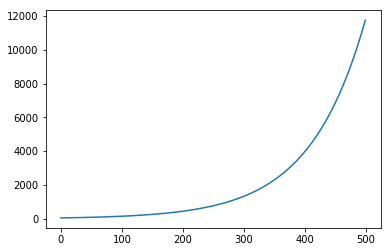

In [55]:
plt.plot(x, y)

In [56]:
batch_updator = ValueUpdator(50, 1.011) # grow the size by 1.2% for every batch

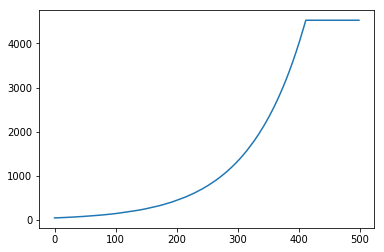

In [57]:
plt.plot([batch_updator.get_current_value(max_value=4524) for _ in range(500)])

In [58]:
batch_updator.reset()

In [60]:
print(batch_updator)

ValueUpdator: 50
